# Initial Experiment of Draco-lite vs Draco

1. Running on ResNet-18 + CIFAR-10 dataset
2. Fail 5 out of 45 compute nodes, randomly simulate byzantine workers for each iteration
3. Bucket size of Draco-lite was setted as 5, redundancy ratio on Draco lite and Draco is $r = 3$ and $r = 15$ respectively.

In [1]:
import numpy as np
import re

In [2]:
acc_file_names = ['draco_lite_bucket5_acc', 'draco_maj_vote_fail5_acc', 'draco_lite_elem_bucket15_acc', 'draco_lite_new_acc']

In [3]:
acc_stats = {}
for acc_file in acc_file_names:
    acc_stats[acc_file] = []
    with open('./'+acc_file, 'rb') as file:
        for line in file.readlines():
            line_content = line.rstrip('\n')
            
            search = re.search("Test set: Average loss: .*, Prec@1: (.*) Prec@5: .*", line_content)
            if search:
                acc = float(search.group(1))
                #if cur_step <= 1000:
                #if cur_step not in acc_stats[acc_file].keys():
                acc_stats[acc_file].append(acc)
                #else:
                #    acc_stats[acc_file][cur_step].append(acc)

In [4]:
#print(acc_stats.keys())
#print
#print(acc_stats['draco_maj_vote_fail5_acc'])
#print
#print(acc_stats['draco_lite_bucket5_acc'])

In [5]:
file_list = ['draco_lite_bucket5', 'draco_maj_vote_fail5', 'draco_lite_elem_bucket15', 'draco_lite_trial']

In [6]:
stats = {}
for f in file_list:
    stat_dict_worker = {}
    stat_dict_master = {}
    print("Processing {} ...".format(f))
    with open(f, 'rb') as worker_file:
        for line in worker_file.readlines():
            line_string = line.rstrip('\n')
            search_sth_worker = re.match('Worker: (.*), Step: (.*), Epoch: .* \[.*/.* \(.*%\)\], Loss: .*, Time Cost: (.*), Comp: (.*), Comm: (.*), Prec@1: (.*), Prec@5: (.*)', line_string)
            master_search_sth =re.match('Master Step: (.*), Method Time Cost: (.*), Update Time Cost: (.*)', line_string)
            # processing worker content
            if search_sth_worker:
                worker_id, cur_step_worker, time_cost, comp_cost, comm_cost = search_sth_worker.group(1), int(search_sth_worker.group(2)), float(search_sth_worker.group(3)), float(search_sth_worker.group(4)), float(search_sth_worker.group(5))
                if cur_step_worker <= 1200:
                    if cur_step_worker not in stat_dict_worker.keys():
                        stat_dict_worker[cur_step_worker] = {'iter_time':[time_cost], 'comp':[comp_cost], 'comm':[comm_cost]}
                    else:
                        stat_dict_worker[cur_step_worker]['iter_time'].append(time_cost)
                        stat_dict_worker[cur_step_worker]['comp'].append(comp_cost)
                        stat_dict_worker[cur_step_worker]['comm'].append(comm_cost)
            # processing master content
            if master_search_sth:
                try:
                    cur_step_master, method_time_cost, update_time_cost = int(master_search_sth.group(1)),float(master_search_sth.group(2)),float(master_search_sth.group(3))
                except ValueError:
                    print(cur_step_master, master_search_sth.group(0))
                    print("======================================================================")
                if cur_step_master <= 1200:
                    if cur_step_master not in stat_dict_master.keys():
                        stat_dict_master[cur_step_master] = [method_time_cost, update_time_cost]
        # sanity check here:
        if len(stat_dict_worker.keys()) != len(stat_dict_master.keys()):
            print(stat_dict_worker.keys(), stat_dict_master.keys())
            for k in stat_dict_worker.keys():
                if k not in stat_dict_master.keys():
                    print("Key {} Messed Up!".format(k))
        assert len(stat_dict_worker.keys()) == len(stat_dict_master.keys())
        stats[f] = [stat_dict_master, stat_dict_worker]

Processing draco_lite_bucket5 ...
Processing draco_maj_vote_fail5 ...
Processing draco_lite_elem_bucket15 ...
Processing draco_lite_trial ...


In [7]:
# processing results
#time_lines = [{}, {}]
time_lines = []
comp_costs = []
comm_costs = []
decode_costs = []

def take_avg(l):
    return sum(l) / float(len(l))

for f in file_list:
    #for t, dict_pairs in enumerate(stats[f]):
    dict_pairs = stats[f]
    _tmp_time_costs = []
    
    _tmp_comp_costs = []
    _tmp_comm_costs = []
    _tmp_decode_costs = []
    
    _time_counter = 0
    m_dict = dict_pairs[0]
    w_dict = dict_pairs[1]

    for i, (k, v) in enumerate(w_dict.iteritems()):
        #if (k-1) % 100 == 0 and k != 1:
        #    print(k, v['iter_time'])
        if (k-1) % 100 == 0 and k != 1:
            _time_counter += max(w_dict[k-1]['iter_time'])
        else:
            _time_counter += max(v['iter_time'])
        
        _tmp_comp_costs.append(take_avg(v['comp']))
        _tmp_comm_costs.append(take_avg(v['comm']))
        _tmp_decode_costs.append(m_dict[k][0])
        
        _time_counter += m_dict[k][0]
        _time_counter += m_dict[k][1]
        if k % 100 == 0:
            _tmp_time_costs.append(_time_counter/60.0)
    time_lines.append(_tmp_time_costs)
    comp_costs.append(_tmp_comp_costs)
    comm_costs.append(_tmp_comm_costs)
    decode_costs.append(_tmp_decode_costs)

# Per Iter Convergence rate Draco vs Draco-lite

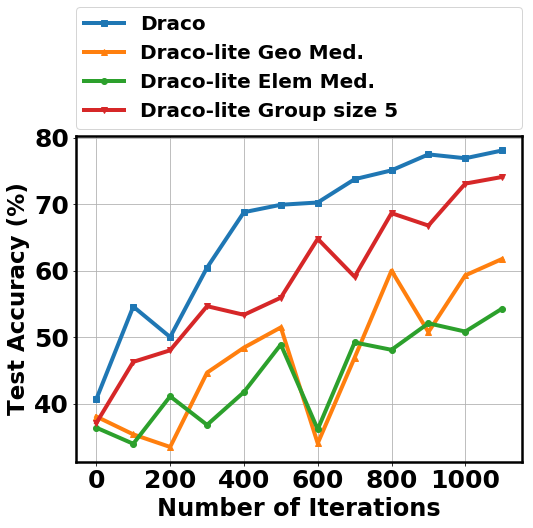

In [19]:
from matplotlib import colors as mcolors
from pylab import *
import numpy as np

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())

rc('axes', linewidth=2.5)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)

__range = np.arange(0, 1200, 100)

plt.plot(__range, acc_stats['draco_maj_vote_fail5_acc'], '-s', linewidth=4.0, label="Draco")

plt.plot(__range, acc_stats['draco_lite_bucket5_acc'], '-^', linewidth=4.0, label="Draco-lite Geo Med.")

plt.plot(__range, acc_stats['draco_lite_elem_bucket15_acc'], '-o', linewidth=4.0, label="Draco-lite Elem Med.")

plt.plot(__range, acc_stats['draco_lite_new_acc'], '-v', linewidth=4.0, label="Draco-lite Group size 5")

plt.xlabel("Number of Iterations",fontsize=24, fontweight='bold')
plt.ylabel("Test Accuracy (%)",fontsize=23, fontweight='bold')
plt.xticks(size=25, fontweight='bold')
plt.yticks(size=25, fontweight='bold')

legend_properties = {'weight':'bold', 'size':20}
ax.xaxis.get_offset_text().set_fontsize(22)
ax.xaxis.get_offset_text().set_weight('bold')
plt.legend(prop=legend_properties, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)

#plt.tight_layout()
#plt.savefig("rev_grad_convergence_fc.pdf", format='pdf', dpi=600, bbox_inches='tight', pad_inches=0.05)
plt.grid()
plt.show()

In [14]:
print(time_lines[3])

[35.16335039606104, 70.22823539266584, 105.20762439381276, 140.23513379044255, 175.56226347765045, 210.92546208086776, 246.11373171936174, 281.3052877891934, 316.6168668215896, 351.78916197556356, 386.95322819497613, 422.2617382780164]


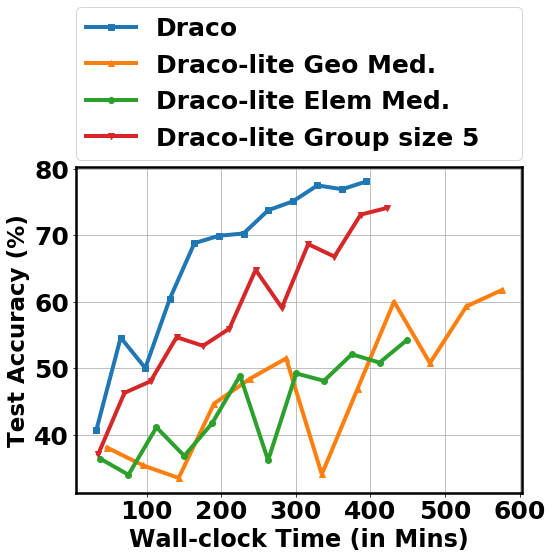

In [20]:
from matplotlib import colors as mcolors
from pylab import *
import numpy as np

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())

rc('axes', linewidth=2.5)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)

plt.plot(time_lines[1], acc_stats['draco_maj_vote_fail5_acc'], '-s', linewidth=4.0, label="Draco")

plt.plot(time_lines[0], acc_stats['draco_lite_bucket5_acc'], '-^', linewidth=4.0, label="Draco-lite Geo Med.")

plt.plot(time_lines[2], acc_stats['draco_lite_elem_bucket15_acc'], '-o', linewidth=4.0, label="Draco-lite Elem Med.")

plt.plot(time_lines[3], acc_stats['draco_lite_new_acc'], '-v', linewidth=4.0, label="Draco-lite Group size 5")


plt.xlabel("Wall-clock Time (in Mins)",fontsize=24, fontweight='bold')
plt.ylabel("Test Accuracy (%)",fontsize=23, fontweight='bold')
plt.xticks(size=25, fontweight='bold')
plt.yticks(size=25, fontweight='bold')

legend_properties = {'weight':'bold', 'size':25}
ax.xaxis.get_offset_text().set_fontsize(25)
ax.xaxis.get_offset_text().set_weight('bold')
plt.legend(prop=legend_properties, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)
plt.grid()
plt.show()

<Figure size 1440x1152 with 0 Axes>

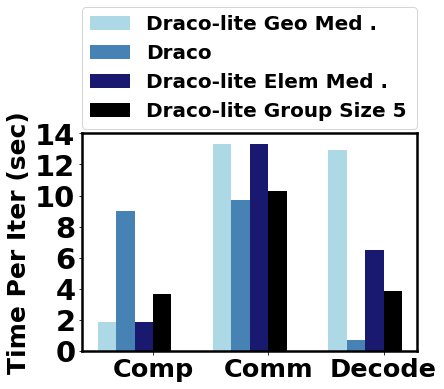

In [25]:
from matplotlib import colors as mcolors
from pylab import *

fig = plt.figure(figsize=(20, 16))
#fig = plt.figure(figsize=(6, 4))

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
rc('axes', linewidth=2.5)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

N = 3
# comp cost, comm cost, decoding cost
#comp_costs.append(_tmp_comp_costs)
#comm_costs.append(_tmp_comm_costs)
#decode_costs.append(_tmp_decode_costs)
def take_avg(l):
    return sum(l) / float(len(l))

draco_lite = [take_avg(comp_costs[0]), take_avg(comm_costs[0]), take_avg(decode_costs[0])]
draco = [take_avg(comp_costs[1]), take_avg(comm_costs[1]), take_avg(decode_costs[1])]
draco_lite_elem = [take_avg(comp_costs[2]), take_avg(comm_costs[2]), take_avg(decode_costs[2])]
draco_lite_group5 = [take_avg(comp_costs[3]), take_avg(comm_costs[3]), take_avg(decode_costs[3])]

ind = np.arange(N)  # the x locations for the groups
width = 0.16      # the width of the bars

fig, ax = plt.subplots()
# GM
rects1 = ax.bar(ind - 2*width, draco_lite, width, color=colors['lightblue'], label="Draco-lite Geo Med .")
# MV
rects2 = ax.bar(ind - width, draco, width, color=colors['steelblue'], label="Draco")

rects3 = ax.bar(ind, draco_lite_elem, width, color=colors['midnightblue'], label="Draco-lite Elem Med .")

rects4 = ax.bar(ind + width, draco_lite_group5, width, color=colors['k'], label="Draco-lite Group Size 5")

# add some text for labels, title and axes ticks
ax.set_ylabel("Time Per Iter (sec)",fontsize=25, fontweight='bold')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Comp', 'Comm', 'Decode'))
#ax.legend()

#ax.set_ylim(0, 500)
plt.xticks(size=25.5, fontweight='bold')
plt.yticks(size=29, fontweight='bold')
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0),size=20)

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

legend_properties = {'weight':'bold', 'size':20}
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0., prop=legend_properties)
#plt.text(-0.45, 0.085, r"$\mathbf{c_2}$", fontsize=20, bbox=dict(ec="k", fc='w', lw=2))
#plt.tight_layout()
#plt.savefig("alexnet_const_err_log.pdf", format='pdf', dpi=600, bbox_inches='tight', pad_inches=0.06)
plt.show()

In [22]:
print(draco_lite)

[1.8861442563013862, 13.295763669892727, 12.901267713309998]
